# **Analysis of the effect of Query Set Size on the performance of Submodular methods used to solve Cold Start Problem with YouTube Dataset**

# Setup

## Get Distil and Submodlib from Decile Repo

In [ ]:
# Get DISTIL
!git clone https://github.com/decile-team/distil.git

# Get submodlib
!git clone https://github.com/decile-team/submodlib.git

Cloning into 'distil'...
remote: Enumerating objects: 3498, done.
remote: Counting objects: 100% (453/453), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 3498 (delta 302), reused 336 (delta 279), pack-reused 3045
Receiving objects: 100% (3498/3498), 23.10 MiB | 28.20 MiB/s, done.
Resolving deltas: 100% (2246/2246), done.
Cloning into 'submodlib'...
remote: Enumerating objects: 2570, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 2570 (delta 2), reused 0 (delta 0), pack-reused 2559
Receiving objects: 100% (2570/2570), 30.57 MiB | 18.04 MiB/s, done.
Resolving deltas: 100% (1911/1911), done.


## Installations

#### *Restart runtime from here after initial install is complete*

In [ ]:
# Installations for DISTIL
!cd distil && pip install -r distil/requirements/requirements.txt
!pip install -r distil/requirements/requirements.txt

# Required installations
!pip install transformers
!pip install datasets

# Installations for Submodlib
!pip install -e ./submodlib/

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'distil/requirements/requirements.txt'
Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple/
  Using cached sphinxcontrib_bibtex-2.6.1-py3-none-any.whl (40 kB)
  Using cached multipledispatch-0.6.0-py3-none-any.whl (11 kB)
  Using cached scikit-learn-0.23.0.tar.gz (7.2 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Obtaining file:///content/submodlib
  Installing build dependencies ... done
  Checking if build

## Imports

In [ ]:
# Standard imports
import copy
import html
import math
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import os
import pandas as pd
import random # Import for query size sampling
import re # Import for baseline regex matching
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import statistics as stat
import string
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
import unicodedata

# Imports for datasets
from collections import Counter
from datasets import Dataset as D
from datasets import load_dataset, load_metric, concatenate_datasets
from io import BytesIO
import requests
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset, ConcatDataset
from tqdm.auto import tqdm
import zipfile

# Additional Imports
from transformers import AutoTokenizer, get_scheduler, BertConfig, AdamW, BertModel

# Imports for active learning
sys.path.append('submodlib/')
sys.path.append('distil/')
from distil.active_learning_strategies import BADGE, SMI, EntropySampling, LeastConfidenceSampling, MarginSampling, RandomSampling   # All active learning strategies showcased in this example
from distil.utils.utils import LabeledToUnlabeledDataset # A utility wrapper class that removes labels from labeled PyTorch dataset objects

## Download GloVe vectorizer

In [ ]:
# Get a simple tokenizer from torchtext. Use GloVe embeddings from torchtext, which will automatically download them.
glove_tokenizer     = get_tokenizer("basic_english")
glove_vectorizer    = GloVe(name='6B', dim=300)

.vector_cache/glove.6B.zip: 862MB [11:45, 1.22MB/s]                           
100%|█████████▉| 399999/400000 [00:40<00:00, 9819.78it/s] 


The above procedure should take 15-30 minutes. The rest of the code should run quicker.

# Data loading, sampling and pre-processing

## Load data from UCI_ML/Github Repository

In [ ]:
# URL of the ZIP file containing the YouTube Spam Collection dataset
zip_url = 'https://archive.ics.uci.edu/static/public/380/youtube+spam+collection.zip'

# Send a GET request to the ZIP file URL
response = requests.get(zip_url, verify=False)

# Extract the ZIP file in memory
with zipfile.ZipFile(BytesIO(response.content), 'r') as zip_ref:
    # Extract all the files from the ZIP archive
    zip_ref.extractall()

# List the files extracted from the ZIP archive
file_list = zip_ref.namelist()

# List to store individual DataFrames
dataframes = []

# Loop through the CSV files and load them into DataFrames
for file_name in file_list:
    if (file_name[0] != '_'):
        df = pd.read_csv(file_name, on_bad_lines='skip')
        dataframes.append(df)

# Concatenate all the DataFrames into one
youtube_df = pd.concat(dataframes, ignore_index=True)

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'archive.ics.uci.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


### Drop irrelevant columns and rename the rest

In [ ]:
# Drop the specified columns
columns_to_drop = ['COMMENT_ID', 'AUTHOR', 'DATE']
youtube_df = youtube_df.drop(columns=columns_to_drop)

# Rename the columns
youtube_df = youtube_df.rename(columns={'CONTENT': 'text', 'CLASS': 'labels'})

In [ ]:
youtube_df.head(10)

,text,labels
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1
5,"Hey, check out my new website!! This site is a...",1
6,Subscribe to my channel ﻿,1
7,i turned it on mute as soon is i came on i jus...,0
8,You should check my channel for Funny VIDEOS!!﻿,1
9,and u should.d check my channel and tell me wh...,1


## Define data pre-processing

### Text pre-processing

In [ ]:
# NLTK Downloads
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Set of punctuation special characters to remove from text
punctuation = set(string.punctuation)

# List of stopwords (commonly used words in English)
english_stopwords = set(stopwords.words('english'))

In [ ]:
# Converts all text to lowercase
def to_lower(text):
    return text.lower()

# Removes punctuation from the text
def remove_punc(text):
    return ''.join(x if x not in punctuation else ' ' for x in text)

# Decodes HTML entities and converts accented text to normal
def to_ascii(text):
    decoded_text = html.unescape(text)  # Decoding HTML entities
    return ''.join(x for x in unicodedata.normalize('NFD', decoded_text) if unicodedata.category(x) != 'Mn')

# Removes stopwords
def remove_stopwords(text):
    return ' '.join(x for x in word_tokenize(text) if x not in english_stopwords)

# Removes BOM Unicode
def remove_bom(text):
    return text.replace('\ufeff', '')

# Remove excess whitespace
def remove_xtra(text):
    return ' '.join(text.split()).strip()

# Process the data by making all text lowercase, removing puncuation, removing stopwords, and converting to ascii
def process_data(data):
    data['text'] = data['text'].apply(to_lower)
    data['text'] = data['text'].apply(to_ascii)
    data['text'] = data['text'].apply(remove_punc)
    data['text'] = data['text'].apply(remove_stopwords)
    data['text'] = data['text'].apply(remove_bom)
    data['text'] = data['text'].apply(remove_xtra)
    return data

### GloVe embeddings

In [ ]:
# Create a full dataset wrapper. This will return a dictionary of 3 items:
#   1. glove_embeddings:    The embedding vectors for the sentence, padded to the max length.
#   2. input_mask:          A tensor that denotes the start idx of the padded part of the sequence
#   3. labels:              A single-element tensor denoting the class.
#
# Creating such an object this way will allow us to utilize DISTIL's interfaces without issue and will also be compatible with the model defined above.
class FullDatasetWrapper(Dataset):

    # Here's how we can get embeddings for each sentence. This will create a list of tensors, which will have varying sizes.
    # We will need to pad each tensor for batching, so we will also need to keep track of the actual final token in each batch so that we do not compute on padded input.
    def __init__(self, datalist, labels):
        self.glove_embeddings   = [glove_vectorizer.get_vecs_by_tokens(glove_tokenizer(data_text), lower_case_backup=True) for data_text in datalist] # Convert text into glove embeddings
        self.labels             = torch.tensor(labels)
        self.pad_length         = max([glove_embedding.shape[0] for glove_embedding in self.glove_embeddings]) # Max sequence length


    def __init__(self, dataframe):
        self.glove_embeddings = []
        valid_labels = []
        for ind in dataframe.index:
            data_text, data_label = dataframe['text'][ind], dataframe['labels'][ind]
            tokens = glove_tokenizer(data_text)
            if not tokens:   # Check if token list is empty
                # print(f"Warning: No tokens for text: {data_text}")
                continue
            glove_embedding = glove_vectorizer.get_vecs_by_tokens(tokens, lower_case_backup=True)
            if glove_embedding.shape[0] == 0:  # Check if no embeddings found
                # print(f"Warning: No embeddings for tokens: {tokens} in text: {data_text}")
                continue
            self.glove_embeddings.append(glove_embedding)
            valid_labels.append(data_label)
        self.labels             = torch.tensor(valid_labels)
        self.pad_length         = max([glove_embedding.shape[0] for glove_embedding in self.glove_embeddings]) # Max sequence length

    def __getitem__(self, index):
        glove_embedding                                     = self.glove_embeddings[index]                              # Get the glove embeddings for sentence
        padded_glove_embedding                              = torch.zeros(self.pad_length, glove_embedding.shape[1])    # Create a padded tensor of zeros to hold them
        padded_glove_embedding[:glove_embedding.shape[0]]   = glove_embedding                                           # Populate the front of the tensor w/ glove embeddings
        input_mask                                          = torch.tensor(glove_embedding.shape[0])                    # Create a single-element tensor denoting index to start ignoring hidden states
        label                                               = self.labels[index]                                        # Get the label and form the dictionary.
        item_dict                                           =   {"glove_embeddings":    padded_glove_embedding,
                                                                "input_mask":           input_mask,
                                                                "labels":               label}
        return item_dict

    def __len__(self):
        return len(self.glove_embeddings)

### AL Label Removal

In [ ]:
class Labeled_to_unlabel(Dataset):

  def __init__(self, wrapped_dataset):
        self.wrapped_dataset = wrapped_dataset
        # give the words here

  def __getitem__(self, index):

        #label = self.wrapped_dataset[index]['labels']
        data = {key:self.wrapped_dataset[index][key] for key in self.wrapped_dataset[index] if key != 'labels'}

        #data = self.wrapped_dataset[index]
        return data

  def __len__(self):
        return len(self.wrapped_dataset)

## Data split and sampling

In [ ]:
seed_values = [42, 96, 35, 52, 11, 87, 26, 75, 60, 49]

#### *Use Ctrl+F10 from here for experiment re-runs (after changing exp_num)*

In [ ]:
exp_num = 9 # CHANGE ME

In [ ]:
# DEFINE RAND_STATE FOR EXPERIMENT RUN
RAND_STATE = seed_values[exp_num-1]
print('Experiment number: {} \tSeed value = {}'.format(exp_num, RAND_STATE))
with open('logs.txt', 'a') as logfile:
    logfile.write('\n\nExperiment number: {} \tSeed value = {}  [YouTube Data]\n'.format(exp_num, RAND_STATE))

Experiment number: 9 	Seed value = 60


### Create test-train split

In [ ]:
# Specify the features (X) and target (y) columns
X = youtube_df.drop(columns=['labels'])
y = youtube_df['labels']

# Perform the train-test split while maintaining the same class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=RAND_STATE, stratify=y)

# Create the train_df and test_df DataFrames
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

### Create imbalance in training data (YouTube Dataset only)

In [ ]:
# Create an approximate 1:10 imbalance with spam to non-spam data
ham_train = train_df[train_df['labels']==0]
spam_train = train_df[train_df['labels']==1]
spam_reduced = spam_train.sample(frac=0.1, random_state=RAND_STATE)
imbalance_df = pd.concat([ham_train, spam_reduced], ignore_index=True)
train_mod_df = shuffle(imbalance_df, random_state=RAND_STATE)

### Find data distribution and calculate imbalance factor

In [ ]:
print('\t  Ham   Spam')
print('Initial  ', ham_train.shape[0], '  ', spam_train.shape[0])
train_class_counts = train_mod_df['labels'].value_counts()
print('Training ', train_class_counts[0], '  ', train_class_counts[1])
test_class_counts = test_df['labels'].value_counts()
print('Testing  ', test_class_counts[0], '  ', test_class_counts[1])

	  Ham   Spam
Initial   808    854
Training  808    85
Testing   143    151


In [ ]:
print("Rare class to majority class ratio ~ 1 :", round(train_class_counts[0]/train_class_counts[1]))

Rare class to majority class ratio ~ 1 : 10


In [ ]:
a, b = len(test_df), len(train_mod_df)
print("Effective test-train split = {}:{}".format(round((100*a)/(a+b)), round((100*b)/(a+b))))

Effective test-train split = 25:75


### Create query set

In [ ]:
# List of commonly found phrases in youtube spam comments
freq_yt_spam_phrases = [
    'check out my latest video', 'click the link', 'dont miss out', 'https',
    'for more information', 'free gift', 'free giveaway', 'win prizes',
    'like and comment', 'limited time offer', 'please help', 'subscribe now',
    'subscribe to my channel', 'visit my website', 'watch my video'
]
query_set_size = len(freq_yt_spam_phrases)
query_data = pd.DataFrame({
    'text':freq_yt_spam_phrases, 'labels': [1]*query_set_size
})

## Apply pre-processing

### Apply text processing

In [ ]:
train_processed_df = process_data(train_mod_df)
# train_processed_df.iloc[10:25]
train_processed_df.head()

,text,labels
68,love shkira,0
268,song means much thank sooooooooooooooooooooooo...,0
343,old good song,0
694,megan fox gorg eminem truly rap god,0
341,came check views p,0


In [ ]:
query_df = process_data(query_data)
query_df.head()

,text,labels
0,check latest video,1
1,click link,1
2,dont miss,1
3,https,1
4,information,1


In [ ]:
test_df = process_data(test_df)

### Get dataset with embeddings

In [ ]:
# GloVe Embeddings for Training Dataset
training_dataset = FullDatasetWrapper(train_processed_df)
# GloVe Embeddings for Query Datas
rare_class_query_set = FullDatasetWrapper(query_df)
# GloVe Embeddings for Testing Dataset
testing_dataset = FullDatasetWrapper(test_df)

# Custom LSTM Model

## Model Definition

In [ ]:
class Average(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, batch_sentence_token_embeddings, input_mask):
        avgs = []
        with torch.no_grad():
            for i in range(batch_sentence_token_embeddings.shape[0]):
                avg = torch.mean(batch_sentence_token_embeddings[i,:input_mask[i],:], dim=0)
                avgs.append(avg)
        return torch.stack(avgs, dim=0)


class SimpleGloVeRNN(nn.Module):

    def __init__(self, num_classes, hidden_dim=512, embedding_dim=256, num_rnn_stacks=1, num_mlp_layers=1):

        super().__init__()
        self.average  = Average()
        self.rnn      = nn.LSTM(batch_first=True, input_size=300, hidden_size=hidden_dim, num_layers=num_rnn_stacks)
        self.activ    = nn.ReLU()

        mlp_layers  = []
        for i in range(num_mlp_layers - 1):
            linear      = nn.Linear(hidden_dim, hidden_dim)
            bn          = nn.BatchNorm1d(hidden_dim)
            mlp_layers.append(linear)
            mlp_layers.append(bn)
            mlp_layers.append(self.activ)
        embed_linear    = nn.Linear(hidden_dim, embedding_dim)
        embed_bn        = nn.BatchNorm1d(hidden_dim)
        mlp_layers.append(embed_linear)
        mlp_layers.append(embed_bn)

        self.mlp            = nn.Sequential(*mlp_layers)
        self.cls            = nn.Linear(embedding_dim, num_classes)
        self.embedding_dim  = embedding_dim
        self.hidden_dim     = hidden_dim


    def get_embedding_dim(self):
        return self.embedding_dim


    def forward(self, glove_embeddings, input_mask, labels=None, freeze=False, last=False):

        if freeze:
            with torch.no_grad():
                ignore_this         = self.average(glove_embeddings, input_mask)
                hidden_states, _    = self.rnn(glove_embeddings)
                # last_hidden_states  = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1).squeeze()  # Using the mask, get the hidden vectors that correspond to the end of each sequence in the batch.
                last_hidden_states = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1)
                if last_hidden_states.size(1) == 1:
                    last_hidden_states = last_hidden_states.squeeze(1) # Squeeze the second dimension if it's 1
                else:
                    last_hidden_states = last_hidden_states.squeeze() # Or just squeeze the last dimension
                # print(last_hidden_states.shape, glove_embeddings.shape, input_mask.shape)
                sentence_embed      = self.mlp(last_hidden_states)
        else:
            ignore_this         = self.average(glove_embeddings, input_mask)                                                            # Added so we can use hooks to get input values for DISTIL's SMI.
            hidden_states, _    = self.rnn(glove_embeddings)                                                                            # Apply RNN
            # last_hidden_states  = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1).squeeze()  # Using the mask, get the hidden vectors that correspond to the end of each sequence in the batch.
            last_hidden_states = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1)
            if last_hidden_states.size(1) == 1:
                last_hidden_states = last_hidden_states.squeeze(1) # Squeeze the second dimension if it's 1
            else:
                last_hidden_states = last_hidden_states.squeeze() # Or just squeeze the last dimension
            # print(last_hidden_states.shape, glove_embeddings.shape, input_mask.shape)
            sentence_embed      = self.mlp(last_hidden_states)                                                                          # Then, apply the MLP on top of the hidden states.
        logits  = self.cls(self.activ(sentence_embed))
        if last:
            return logits, sentence_embed
        else:
            return logits

## Custom Training Method

In [ ]:
class data_train:

    def __init__(self, num_cls=2, hidden_dim=256, embedding_dim=256, num_rnn_stacks=2, mlp_layers=2, batch_size=20) -> None:
        self.model = SimpleGloVeRNN(num_cls, hidden_dim, embedding_dim, num_rnn_stacks, mlp_layers)
        self.num_cls = num_cls
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.num_rnn_stacks = num_rnn_stacks
        self.mlp_layers = mlp_layers
        self.batch_size = batch_size
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)

    def get_param_count(self):
        # How many parameters? Should be MUCH less than BERT (110 million)! Can configure above params to make the model larger/smaller.
        param_count = 0
        for param in self.model.parameters():
            size_list   = param.size()
            param_count += torch.prod(torch.tensor(size_list)).item()
        print("Parameters:", F"{param_count:,}")
        return param_count

    def check_batching(self, training_dataset):
        dataloader = DataLoader(training_dataset, batch_size=2, shuffle=False)
        for batch_dict in dataloader:
            batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
            output = self.model(**batch_dict)
            print(output.shape)

    def train(self, training_dataset, epochs=150, lr=1e-2):
        dataloader = DataLoader(training_dataset, batch_size=self.batch_size, shuffle=False)
        optimizer = optim.SGD(self.model.parameters(), lr=1e-2)
        self.model.train()
        losses = []
        for i in range(epochs):
            epoch_loss, num_batches = 0, 0
            for batch_dict in dataloader:
                batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
                optimizer.zero_grad()
                out   = self.model(**batch_dict)
                loss  = torch.nn.functional.cross_entropy(out, batch_dict["labels"])
                loss.backward()
                optimizer.step()
                epoch_loss, num_batches = epoch_loss+loss.item(), num_batches+1
            avg_loss = epoch_loss/num_batches if num_batches>0 else 0
            if (i+1)%5==0:
                print('Epoch:', (i+1), '\tLoss =', avg_loss)
            losses.append(avg_loss)
        self.model.eval()
        return losses

    def verify_output_emeddings(self, training_dataset):
        dataloader = DataLoader(training_dataset, batch_size=2, shuffle=False)
        for batch_dict in dataloader:
            batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
            output, embeddings = self.model(**batch_dict, last=True, freeze=True)
            print(output)
            print(embeddings.shape)

    def get_test_metrics(self, testing_dataset):
        dataloader = DataLoader(testing_dataset, batch_size=self.batch_size, shuffle=False)
        # Initialize counters
        tp = fp = fn = tn = 0

        self.model.eval()
        with torch.no_grad():
            for batch_dict in dataloader:
                batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
                # Get model outputs
                outputs = self.model(**batch_dict)
                # Calculate predictions from outputs (assuming binary classification with threshold at 0.5)
                # Modify the threshold and prediction calculation if necessary
                predictions = torch.argmax(outputs, dim=1)
                # Get true labels
                true_labels = batch_dict["labels"]
                # Update confusion matrix
                conf_mat = confusion_matrix(true_labels.cpu().numpy(), predictions.cpu().numpy(), labels=[0, 1])
                tn_, fp_, fn_, tp_ = conf_mat.ravel() if conf_mat.size == 4 else (0, 0, 0, 0)
                tp, fp, fn, tn = tp+tp_, fp+fp_, fn+fn_, tn+tn_

        acc = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (tp + fn) if (tp + fn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        fdr = fp / (tp + fp) if (tp + fp) > 0 else 0
        mcc_numerator = (tp * tn) - (fp * fn)
        mcc_denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
        mcc = mcc_numerator / mcc_denominator if mcc_denominator > 0 else 0

        metrics = {
            'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn, 'acc': acc, 'f1': f1,
            'ppv': ppv, 'tpr': tpr, 'fpr': fpr, 'fnr': fnr,
            'tnr': tnr, 'npv': npv, 'fdr': fdr, 'mcc': mcc
        }

        return metrics


### Metric_dict Definition

In [ ]:
metric_dict = {
    'tp': "True Positive Count", 'fp': 'False Positive Count',
    'fn': "False Negative Count", 'tn': 'True Negative Count',
    'acc': "Accuracy", 'f1': 'F1-score | F-measure',
    'ppv': "Positive Predictive Value | Precision",
    'tpr': 'True Positive Rate | Recall | Sensitivity',
    'fpr': "False Positive Rate | Type I error",
    'fnr': 'False Negative Rate | Type II error',
    'tnr': "True Negative Rate | Specificity",
    'npv': 'Negative Predictive Value', 'fdr': "False Discovery Rate",
    'mcc': 'Matthews Correlation Coefficient',

}
metric_dict

{'tp': 'True Positive Count',
 'fp': 'False Positive Count',
 'fn': 'False Negative Count',
 'tn': 'True Negative Count',
 'acc': 'Accuracy',
 'f1': 'F1-score | F-measure',
 'ppv': 'Positive Predictive Value | Precision',
 'tpr': 'True Positive Rate | Recall | Sensitivity',
 'fpr': 'False Positive Rate | Type I error',
 'fnr': 'False Negative Rate | Type II error',
 'tnr': 'True Negative Rate | Specificity',
 'npv': 'Negative Predictive Value',
 'fdr': 'False Discovery Rate',
 'mcc': 'Matthews Correlation Coefficient'}

# Active Learning

## Define Selection Strategy arguments

In [ ]:
budget = sum(train_class_counts)//20 # Budget is set to 5% of the total training dataset
print(budget)

44


In [ ]:
selection_strategy_args = {
    'device':        "cpu",                  # Use the device used in training
    'batch_size':    20,                    # Use the batch size used in training
    'smi_function':  'logdetmi',              # Use a facility location function, which captures representation information
    'metric':        'cosine',             # Use cosine similarity when determining the likeness of two data points
    'optimizer':     'LazyGreedy',          # When doing submodular maximization, use the lazy greedy optimizer
    'embedding_type': 'features',          # IMPORTANT: NEED TO USE PRETRAINED GLOVE FEATURES FOR COLD START SELECTION!
    'layer_name':    'average'             # We can do so by specifying the layer we wish to extract those features from.
}

In [ ]:
qry_sz, train_sz = len(rare_class_query_set), len(training_dataset)

## Query Set Size = 100%

In [ ]:
LSTM_pc100 = data_train()

In [ ]:
random.seed(RAND_STATE)
ablated_query_set = Subset(rare_class_query_set, random.sample(range(qry_sz), int(1.00 * qry_sz)))
print('Query Set Size w.r.t. Unlabeled Data = {}%'.format(round(100*qry_sz/train_sz, 2)))
print('Query Set Usage: 100%')

Query Set Size w.r.t. Unlabeled Data = 1.69%
Query Set Usage: 100%


### Subset Selection with 100% of Query Set

In [ ]:
selection_strategy_args['device'] = LSTM_pc100.device
pc100_selection_strategy = SMI(training_dataset, Labeled_to_unlabel(training_dataset), ablated_query_set, LSTM_pc100.model, LSTM_pc100.num_cls, selection_strategy_args)
pc100_selected_idx = pc100_selection_strategy.select(budget)
pc100_human_labeled_dataset = Subset(training_dataset, pc100_selected_idx)

pc100_class_counts = [0 for x in range(LSTM_pc100.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in pc100_human_labeled_dataset:
    pc100_class_counts[_['labels']] += 1

# Print each class count

for class_idx, class_count in enumerate(pc100_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Class 0 count: 23
Class 1 count: 21


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nQuery Set Size w.r.t. Unlabeled Data = {}%'.format(round(100*qry_sz/train_sz, 2)))
    logfile.write('\nQuery Set Usage: 100% \n')
    for class_idx, class_count in enumerate(pc100_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Selection using 100% of Query Set

In [ ]:
losses_pc100 = LSTM_pc100.train(pc100_human_labeled_dataset, epochs=50)

Epoch: 5 	Loss = 0.20546423147122064
Epoch: 10 	Loss = 0.11245974153280258
Epoch: 15 	Loss = 0.074991874396801
Epoch: 20 	Loss = 0.05510032922029495
Epoch: 25 	Loss = 0.043227419878045716
Epoch: 30 	Loss = 0.035420787831147514
Epoch: 35 	Loss = 0.029818149283528328
Epoch: 40 	Loss = 0.025703911979993183
Epoch: 45 	Loss = 0.02249570128818353
Epoch: 50 	Loss = 0.019989396755894024


### Test Performance - Model trained on selecting using 100% of Query Set

In [ ]:
pc100_metrics = LSTM_pc100.get_test_metrics(testing_dataset)

In [ ]:
pc100_metrics

{'tp': 94,
 'fp': 22,
 'fn': 57,
 'tn': 121,
 'acc': 0.7312925170068028,
 'f1': 0.704119850187266,
 'ppv': 0.8103448275862069,
 'tpr': 0.6225165562913907,
 'fpr': 0.15384615384615385,
 'fnr': 0.37748344370860926,
 'tnr': 0.8461538461538461,
 'npv': 0.6797752808988764,
 'fdr': 0.1896551724137931,
 'mcc': 0.4792752742320504}

In [ ]:
pc100_metrics['name'] = 'Size-100%'

## Query Set Size = 80%

In [ ]:
LSTM_pc80 = data_train()

In [ ]:
random.seed(RAND_STATE)
ablated_query_set = Subset(rare_class_query_set, random.sample(range(qry_sz), int(0.80 * qry_sz)))
print('Query Set Size w.r.t. Unlabeled Data = {}%'.format(round(80*qry_sz/train_sz, 2)))
print('Query Set Usage: 80%')

Query Set Size w.r.t. Unlabeled Data = 1.35%
Query Set Usage: 80%


### Subset Selection with 80% of Query Set

In [ ]:
selection_strategy_args['device'] = LSTM_pc80.device
pc80_selection_strategy = SMI(training_dataset, Labeled_to_unlabel(training_dataset), ablated_query_set, LSTM_pc80.model, LSTM_pc80.num_cls, selection_strategy_args)
pc80_selected_idx = pc80_selection_strategy.select(budget)
pc80_human_labeled_dataset = Subset(training_dataset, pc80_selected_idx)

pc80_class_counts = [0 for x in range(LSTM_pc80.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in pc80_human_labeled_dataset:
    pc80_class_counts[_['labels']] += 1

# Print each class count

for class_idx, class_count in enumerate(pc80_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Class 0 count: 27
Class 1 count: 17


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nQuery Set Size w.r.t. Unlabeled Data = {}%'.format(round(80*qry_sz/train_sz, 2)))
    logfile.write('\nQuery Set Usage: 80% \n')
    for class_idx, class_count in enumerate(pc80_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Selection using 80% of Query Set

In [ ]:
losses_pc80 = LSTM_pc80.train(pc80_human_labeled_dataset, epochs=50)

Epoch: 5 	Loss = 0.15526603907346725
Epoch: 10 	Loss = 0.08532629534602165
Epoch: 15 	Loss = 0.057045089080929756
Epoch: 20 	Loss = 0.04217539603511492
Epoch: 25 	Loss = 0.033152236913641296
Epoch: 30 	Loss = 0.027173434384167194
Epoch: 35 	Loss = 0.022938299148033064
Epoch: 40 	Loss = 0.01981069768468539
Epoch: 45 	Loss = 0.017407704920818407
Epoch: 50 	Loss = 0.015506520556906859


### Test Performance - Model trained on selecting using 80% of Query Set

In [ ]:
pc80_metrics = LSTM_pc80.get_test_metrics(testing_dataset)

In [ ]:
pc80_metrics

{'tp': 70,
 'fp': 7,
 'fn': 81,
 'tn': 136,
 'acc': 0.7006802721088435,
 'f1': 0.6140350877192983,
 'ppv': 0.9090909090909091,
 'tpr': 0.46357615894039733,
 'fpr': 0.04895104895104895,
 'fnr': 0.5364238410596026,
 'tnr': 0.951048951048951,
 'npv': 0.6267281105990783,
 'fdr': 0.09090909090909091,
 'mcc': 0.4713427839410994}

In [ ]:
pc80_metrics['name'] = 'Size-80%'

## Query Set Size = 60%

In [ ]:
LSTM_pc60 = data_train()

In [ ]:
random.seed(RAND_STATE)
ablated_query_set = Subset(rare_class_query_set, random.sample(range(qry_sz), int(0.60 * qry_sz)))
print('Query Set Size w.r.t. Unlabeled Data = {}%'.format(round(60*qry_sz/train_sz, 2)))
print('Query Set Usage: 60%')

Query Set Size w.r.t. Unlabeled Data = 1.01%
Query Set Usage: 60%


### Subset Selection with 60% of Query Set

In [ ]:
selection_strategy_args['device'] = LSTM_pc60.device
pc60_selection_strategy = SMI(training_dataset, Labeled_to_unlabel(training_dataset), ablated_query_set, LSTM_pc60.model, LSTM_pc60.num_cls, selection_strategy_args)
pc60_selected_idx = pc60_selection_strategy.select(budget)
pc60_human_labeled_dataset = Subset(training_dataset, pc60_selected_idx)

pc60_class_counts = [0 for x in range(LSTM_pc60.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in pc60_human_labeled_dataset:
    pc60_class_counts[_['labels']] += 1

# Print each class count

for class_idx, class_count in enumerate(pc60_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Class 0 count: 28
Class 1 count: 16


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nQuery Set Size w.r.t. Unlabeled Data = {}%'.format(round(60*qry_sz/train_sz, 2)))
    logfile.write('\nQuery Set Usage: 60% \n')
    for class_idx, class_count in enumerate(pc60_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Selection using 60% of Query Set

In [ ]:
losses_pc60 = LSTM_pc60.train(pc60_human_labeled_dataset, epochs=50)

Epoch: 5 	Loss = 0.16260246435801187
Epoch: 10 	Loss = 0.0865451196829478
Epoch: 15 	Loss = 0.05762707255780697
Epoch: 20 	Loss = 0.04255829006433487
Epoch: 25 	Loss = 0.03339141793549061
Epoch: 30 	Loss = 0.027297837659716606
Epoch: 35 	Loss = 0.023033255711197853
Epoch: 40 	Loss = 0.019871414328614872
Epoch: 45 	Loss = 0.017447054386138916
Epoch: 50 	Loss = 0.015521124005317688


### Test Performance - Model trained on selecting using 60% of Query Set

In [ ]:
pc60_metrics = LSTM_pc60.get_test_metrics(testing_dataset)

In [ ]:
pc60_metrics

{'tp': 103,
 'fp': 31,
 'fn': 48,
 'tn': 112,
 'acc': 0.7312925170068028,
 'f1': 0.7228070175438597,
 'ppv': 0.7686567164179104,
 'tpr': 0.6821192052980133,
 'fpr': 0.21678321678321677,
 'fnr': 0.31788079470198677,
 'tnr': 0.7832167832167832,
 'npv': 0.7,
 'fdr': 0.23134328358208955,
 'mcc': 0.466993400818927}

In [ ]:
pc60_metrics['name'] = 'Size-60%'

## Query Set Size = 40%

In [ ]:
LSTM_pc40 = data_train()

In [ ]:
random.seed(RAND_STATE)
ablated_query_set = Subset(rare_class_query_set, random.sample(range(qry_sz), int(0.40 * qry_sz)))
print('Query Set Size w.r.t. Unlabeled Data = {}%'.format(round(40*qry_sz/train_sz, 2)))
print('Query Set Usage: 40%')

Query Set Size w.r.t. Unlabeled Data = 0.68%
Query Set Usage: 40%


### Subset Selection with 40% of Query Set

In [ ]:
selection_strategy_args['device'] = LSTM_pc40.device
pc40_selection_strategy = SMI(training_dataset, Labeled_to_unlabel(training_dataset), ablated_query_set, LSTM_pc40.model, LSTM_pc40.num_cls, selection_strategy_args)
pc40_selected_idx = pc40_selection_strategy.select(budget)
pc40_human_labeled_dataset = Subset(training_dataset, pc40_selected_idx)

pc40_class_counts = [0 for x in range(LSTM_pc40.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in pc40_human_labeled_dataset:
    pc40_class_counts[_['labels']] += 1

# Print each class count

for class_idx, class_count in enumerate(pc40_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Class 0 count: 31
Class 1 count: 13


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nQuery Set Size w.r.t. Unlabeled Data = {}%'.format(round(40*qry_sz/train_sz, 2)))
    logfile.write('\nQuery Set Usage: 40% \n')
    for class_idx, class_count in enumerate(pc40_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Selection using 40% of Query Set

In [ ]:
losses_pc40 = LSTM_pc40.train(pc40_human_labeled_dataset, epochs=50)

Epoch: 5 	Loss = 0.16203777740399042
Epoch: 10 	Loss = 0.08723653232057889
Epoch: 15 	Loss = 0.058022623881697655
Epoch: 20 	Loss = 0.04250028915703297
Epoch: 25 	Loss = 0.03308990846077601
Epoch: 30 	Loss = 0.026927624829113483
Epoch: 35 	Loss = 0.022641837286452453
Epoch: 40 	Loss = 0.019459102302789688
Epoch: 45 	Loss = 0.017000762435297172
Epoch: 50 	Loss = 0.015057105105370283


### Test Performance - Model trained on selecting using 40% of Query Set

In [ ]:
pc40_metrics = LSTM_pc40.get_test_metrics(testing_dataset)

In [ ]:
pc40_metrics

{'tp': 43,
 'fp': 5,
 'fn': 108,
 'tn': 138,
 'acc': 0.6156462585034014,
 'f1': 0.4321608040201005,
 'ppv': 0.8958333333333334,
 'tpr': 0.2847682119205298,
 'fpr': 0.03496503496503497,
 'fnr': 0.7152317880794702,
 'tnr': 0.965034965034965,
 'npv': 0.5609756097560976,
 'fdr': 0.10416666666666667,
 'mcc': 0.3378051587016126}

In [ ]:
pc40_metrics['name'] = 'Size-40%'

## Query Set Size = 20%

In [ ]:
LSTM_pc20 = data_train()

In [ ]:
random.seed(RAND_STATE)
ablated_query_set = Subset(rare_class_query_set, random.sample(range(qry_sz), int(0.20 * qry_sz)))
print('Query Set Size w.r.t. Unlabeled Data = {}%'.format(round(20*qry_sz/train_sz, 2)))
print('Query Set Usage: 20%')

Query Set Size w.r.t. Unlabeled Data = 0.34%
Query Set Usage: 20%


### Subset Selection with 20% of Query Set

In [ ]:
selection_strategy_args['device'] = LSTM_pc20.device
pc20_selection_strategy = SMI(training_dataset, Labeled_to_unlabel(training_dataset), ablated_query_set, LSTM_pc20.model, LSTM_pc20.num_cls, selection_strategy_args)
pc20_selected_idx = pc20_selection_strategy.select(budget)
pc20_human_labeled_dataset = Subset(training_dataset, pc20_selected_idx)

pc20_class_counts = [0 for x in range(LSTM_pc20.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in pc20_human_labeled_dataset:
    pc20_class_counts[_['labels']] += 1

# Print each class count

for class_idx, class_count in enumerate(pc20_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Class 0 count: 30
Class 1 count: 14


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nQuery Set Size w.r.t. Unlabeled Data = {}%'.format(round(20*qry_sz/train_sz, 2)))
    logfile.write('\nQuery Set Usage: 20% \n')
    for class_idx, class_count in enumerate(pc20_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Selection using 20% of Query Set

In [ ]:
losses_pc20 = LSTM_pc20.train(pc20_human_labeled_dataset, epochs=50)

Epoch: 5 	Loss = 0.2245840827624003
Epoch: 10 	Loss = 0.1254371479153633
Epoch: 15 	Loss = 0.08560373882452647
Epoch: 20 	Loss = 0.063763577491045
Epoch: 25 	Loss = 0.05044159417351087
Epoch: 30 	Loss = 0.04171334827939669
Epoch: 35 	Loss = 0.03530591415862242
Epoch: 40 	Loss = 0.03071822226047516
Epoch: 45 	Loss = 0.027065806090831757
Epoch: 50 	Loss = 0.02417423576116562


### Test Performance - Model trained on selecting using 20% of Query Set

In [ ]:
pc20_metrics = LSTM_pc20.get_test_metrics(testing_dataset)

In [ ]:
pc20_metrics

{'tp': 52,
 'fp': 3,
 'fn': 99,
 'tn': 140,
 'acc': 0.6530612244897959,
 'f1': 0.5048543689320388,
 'ppv': 0.9454545454545454,
 'tpr': 0.3443708609271523,
 'fpr': 0.02097902097902098,
 'fnr': 0.6556291390728477,
 'tnr': 0.9790209790209791,
 'npv': 0.5857740585774058,
 'fdr': 0.05454545454545454,
 'mcc': 0.41448159873626483}

In [ ]:
pc20_metrics['name'] = 'Size-20%'

# Experiment Results

## Graph - Training Losses

In [ ]:
def plot_multiple_losses(loss_dict):
    plt.figure(figsize=(16, 6))
    for strat,losses in loss_dict.items():
        plt.plot(losses, label=strat)
    plt.title('Training Losses for SMI with different Query Set Sizes: Exp {} [YouTube Data]'.format(exp_num))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

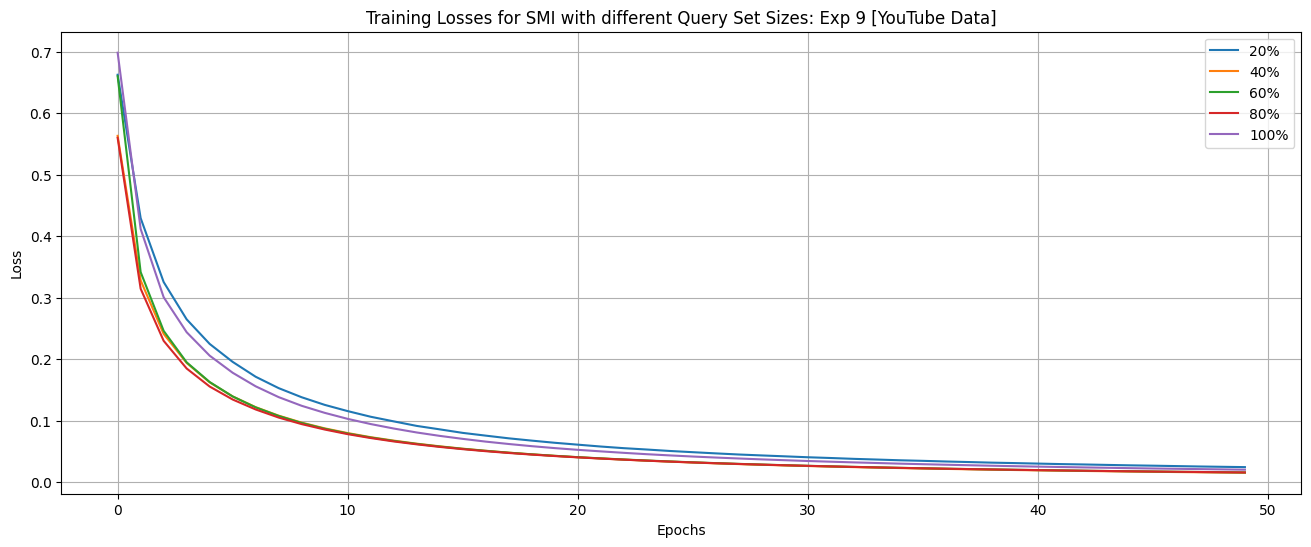

In [ ]:
plot_multiple_losses({
    '20%': losses_pc20, '40%': losses_pc40,
    '60%': losses_pc60, '80%': losses_pc80,
    '100%': losses_pc100
})

## Metric Compilation

In [ ]:
metric_list = [pc20_metrics, pc40_metrics, pc60_metrics,
               pc80_metrics, pc100_metrics]

In [ ]:
metrics_compiled = {k: {
    metric['name']: metric[k] for metric in metric_list
    } for k in metric_list[0] if (k!='name')}
metrics_compiled

{'tp': {'Size-20%': 52,
  'Size-40%': 43,
  'Size-60%': 103,
  'Size-80%': 70,
  'Size-100%': 94},
 'fp': {'Size-20%': 3,
  'Size-40%': 5,
  'Size-60%': 31,
  'Size-80%': 7,
  'Size-100%': 22},
 'fn': {'Size-20%': 99,
  'Size-40%': 108,
  'Size-60%': 48,
  'Size-80%': 81,
  'Size-100%': 57},
 'tn': {'Size-20%': 140,
  'Size-40%': 138,
  'Size-60%': 112,
  'Size-80%': 136,
  'Size-100%': 121},
 'acc': {'Size-20%': 0.6530612244897959,
  'Size-40%': 0.6156462585034014,
  'Size-60%': 0.7312925170068028,
  'Size-80%': 0.7006802721088435,
  'Size-100%': 0.7312925170068028},
 'f1': {'Size-20%': 0.5048543689320388,
  'Size-40%': 0.4321608040201005,
  'Size-60%': 0.7228070175438597,
  'Size-80%': 0.6140350877192983,
  'Size-100%': 0.704119850187266},
 'ppv': {'Size-20%': 0.9454545454545454,
  'Size-40%': 0.8958333333333334,
  'Size-60%': 0.7686567164179104,
  'Size-80%': 0.9090909090909091,
  'Size-100%': 0.8103448275862069},
 'tpr': {'Size-20%': 0.3443708609271523,
  'Size-40%': 0.284768211920

In [ ]:
with open('logs.txt', 'a') as tf:
    tf.write('\n\nExp{}_metrics'.format(exp_num))
    tf.write(' = {')
    for k in metric_list[0]:
        if (k!='name'):
            tf.write("'{}': ".format(k))
            tf.write('{')
            for metric in metric_list[:-1]:
                tf.write("'{}': {}, ".format(metric['name'], round(metric[k], 5)))
            tf.write("'{}': {}".format(metric_list[-1]['name'], round(metric_list[-1][k], 5)))
            tf.write('}, ')

with open('logs.txt', 'r') as tf:
    contents = tf.read()
contents = contents[:-2]
with open('logs.txt', 'w') as tf:
    tf.write(contents)
    tf.write('}')


NOTE: Execute only till here for each experimental run. After each run, copy metrics generated in above output cell or output txt file and paste in the below cell for the respective experiment. After completing all 10 experiments, run below cells only by uncommenting to generate mean metrics and performance graphs.

## Overall Metric Stats

In [ ]:
import statistics as stat
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
def get_stats(values):
    return {'range': (min(values), max(values)), 'avg': round(sum(values)/len(values), 5), 'std_dev': round(stat.stdev(values), 5)}

In [ ]:
def end_of_exp():
    Exp1_metrics = {'tp': {'Size-20%': 136, 'Size-40%': 142, 'Size-60%': 103, 'Size-80%': 118, 'Size-100%': 139}, 'fp': {'Size-20%': 75, 'Size-40%': 73, 'Size-60%': 17, 'Size-80%': 36, 'Size-100%': 45}, 'fn': {'Size-20%': 15, 'Size-40%': 9, 'Size-60%': 48, 'Size-80%': 33, 'Size-100%': 12}, 'tn': {'Size-20%': 67, 'Size-40%': 69, 'Size-60%': 125, 'Size-80%': 106, 'Size-100%': 97}, 'acc': {'Size-20%': 0.69283, 'Size-40%': 0.72014, 'Size-60%': 0.77816, 'Size-80%': 0.76451, 'Size-100%': 0.80546}, 'f1': {'Size-20%': 0.75138, 'Size-40%': 0.77596, 'Size-60%': 0.76015, 'Size-80%': 0.77377, 'Size-100%': 0.82985}, 'ppv': {'Size-20%': 0.64455, 'Size-40%': 0.66047, 'Size-60%': 0.85833, 'Size-80%': 0.76623, 'Size-100%': 0.75543}, 'tpr': {'Size-20%': 0.90066, 'Size-40%': 0.9404, 'Size-60%': 0.68212, 'Size-80%': 0.78146, 'Size-100%': 0.92053}, 'fpr': {'Size-20%': 0.52817, 'Size-40%': 0.51408, 'Size-60%': 0.11972, 'Size-80%': 0.25352, 'Size-100%': 0.3169}, 'fnr': {'Size-20%': 0.09934, 'Size-40%': 0.0596, 'Size-60%': 0.31788, 'Size-80%': 0.21854, 'Size-100%': 0.07947}, 'tnr': {'Size-20%': 0.47183, 'Size-40%': 0.48592, 'Size-60%': 0.88028, 'Size-80%': 0.74648, 'Size-100%': 0.6831}, 'npv': {'Size-20%': 0.81707, 'Size-40%': 0.88462, 'Size-60%': 0.72254, 'Size-80%': 0.76259, 'Size-100%': 0.88991}, 'fdr': {'Size-20%': 0.35545, 'Size-40%': 0.33953, 'Size-60%': 0.14167, 'Size-80%': 0.23377, 'Size-100%': 0.24457}, 'mcc': {'Size-20%': 0.41467, 'Size-40%': 0.48205, 'Size-60%': 0.57156, 'Size-80%': 0.52838, 'Size-100%': 0.62414}}
    Exp2_metrics = {'tp': {'Size-20%': 95, 'Size-40%': 93, 'Size-60%': 81, 'Size-80%': 120, 'Size-100%': 138}, 'fp': {'Size-20%': 17, 'Size-40%': 5, 'Size-60%': 9, 'Size-80%': 43, 'Size-100%': 53}, 'fn': {'Size-20%': 56, 'Size-40%': 58, 'Size-60%': 70, 'Size-80%': 31, 'Size-100%': 13}, 'tn': {'Size-20%': 126, 'Size-40%': 138, 'Size-60%': 134, 'Size-80%': 100, 'Size-100%': 90}, 'acc': {'Size-20%': 0.7517, 'Size-40%': 0.78571, 'Size-60%': 0.73129, 'Size-80%': 0.7483, 'Size-100%': 0.77551}, 'f1': {'Size-20%': 0.72243, 'Size-40%': 0.74699, 'Size-60%': 0.6722, 'Size-80%': 0.76433, 'Size-100%': 0.80702}, 'ppv': {'Size-20%': 0.84821, 'Size-40%': 0.94898, 'Size-60%': 0.9, 'Size-80%': 0.7362, 'Size-100%': 0.72251}, 'tpr': {'Size-20%': 0.62914, 'Size-40%': 0.61589, 'Size-60%': 0.53642, 'Size-80%': 0.7947, 'Size-100%': 0.91391}, 'fpr': {'Size-20%': 0.11888, 'Size-40%': 0.03497, 'Size-60%': 0.06294, 'Size-80%': 0.3007, 'Size-100%': 0.37063}, 'fnr': {'Size-20%': 0.37086, 'Size-40%': 0.38411, 'Size-60%': 0.46358, 'Size-80%': 0.2053, 'Size-100%': 0.08609}, 'tnr': {'Size-20%': 0.88112, 'Size-40%': 0.96503, 'Size-60%': 0.93706, 'Size-80%': 0.6993, 'Size-100%': 0.62937}, 'npv': {'Size-20%': 0.69231, 'Size-40%': 0.70408, 'Size-60%': 0.65686, 'Size-80%': 0.76336, 'Size-100%': 0.87379}, 'fdr': {'Size-20%': 0.15179, 'Size-40%': 0.05102, 'Size-60%': 0.1, 'Size-80%': 0.2638, 'Size-100%': 0.27749}, 'mcc': {'Size-20%': 0.52517, 'Size-40%': 0.61594, 'Size-60%': 0.51349, 'Size-80%': 0.49677, 'Size-100%': 0.56917}}
    Exp3_metrics = {'tp': {'Size-20%': 67, 'Size-40%': 65, 'Size-60%': 76, 'Size-80%': 91, 'Size-100%': 70}, 'fp': {'Size-20%': 9, 'Size-40%': 9, 'Size-60%': 11, 'Size-80%': 12, 'Size-100%': 7}, 'fn': {'Size-20%': 84, 'Size-40%': 86, 'Size-60%': 75, 'Size-80%': 60, 'Size-100%': 81}, 'tn': {'Size-20%': 133, 'Size-40%': 133, 'Size-60%': 131, 'Size-80%': 130, 'Size-100%': 135}, 'acc': {'Size-20%': 0.68259, 'Size-40%': 0.67577, 'Size-60%': 0.70648, 'Size-80%': 0.75427, 'Size-100%': 0.69966}, 'f1': {'Size-20%': 0.59031, 'Size-40%': 0.57778, 'Size-60%': 0.63866, 'Size-80%': 0.71654, 'Size-100%': 0.61404}, 'ppv': {'Size-20%': 0.88158, 'Size-40%': 0.87838, 'Size-60%': 0.87356, 'Size-80%': 0.8835, 'Size-100%': 0.90909}, 'tpr': {'Size-20%': 0.44371, 'Size-40%': 0.43046, 'Size-60%': 0.50331, 'Size-80%': 0.60265, 'Size-100%': 0.46358}, 'fpr': {'Size-20%': 0.06338, 'Size-40%': 0.06338, 'Size-60%': 0.07746, 'Size-80%': 0.08451, 'Size-100%': 0.0493}, 'fnr': {'Size-20%': 0.55629, 'Size-40%': 0.56954, 'Size-60%': 0.49669, 'Size-80%': 0.39735, 'Size-100%': 0.53642}, 'tnr': {'Size-20%': 0.93662, 'Size-40%': 0.93662, 'Size-60%': 0.92254, 'Size-80%': 0.91549, 'Size-100%': 0.9507}, 'npv': {'Size-20%': 0.6129, 'Size-40%': 0.60731, 'Size-60%': 0.63592, 'Size-80%': 0.68421, 'Size-100%': 0.625}, 'fdr': {'Size-20%': 0.11842, 'Size-40%': 0.12162, 'Size-60%': 0.12644, 'Size-80%': 0.1165, 'Size-100%': 0.09091}, 'mcc': {'Size-20%': 0.43367, 'Size-40%': 0.42224, 'Size-60%': 0.46579, 'Size-80%': 0.54236, 'Size-100%': 0.47039}}
    Exp4_metrics = {'tp': {'Size-20%': 76, 'Size-40%': 120, 'Size-60%': 94, 'Size-80%': 126, 'Size-100%': 122}, 'fp': {'Size-20%': 5, 'Size-40%': 29, 'Size-60%': 26, 'Size-80%': 39, 'Size-100%': 41}, 'fn': {'Size-20%': 75, 'Size-40%': 31, 'Size-60%': 57, 'Size-80%': 25, 'Size-100%': 29}, 'tn': {'Size-20%': 136, 'Size-40%': 112, 'Size-60%': 115, 'Size-80%': 102, 'Size-100%': 100}, 'acc': {'Size-20%': 0.72603, 'Size-40%': 0.79452, 'Size-60%': 0.71575, 'Size-80%': 0.78082, 'Size-100%': 0.76027}, 'f1': {'Size-20%': 0.65517, 'Size-40%': 0.8, 'Size-60%': 0.69373, 'Size-80%': 0.79747, 'Size-100%': 0.77707}, 'ppv': {'Size-20%': 0.93827, 'Size-40%': 0.80537, 'Size-60%': 0.78333, 'Size-80%': 0.76364, 'Size-100%': 0.74847}, 'tpr': {'Size-20%': 0.50331, 'Size-40%': 0.7947, 'Size-60%': 0.62252, 'Size-80%': 0.83444, 'Size-100%': 0.80795}, 'fpr': {'Size-20%': 0.03546, 'Size-40%': 0.20567, 'Size-60%': 0.1844, 'Size-80%': 0.2766, 'Size-100%': 0.29078}, 'fnr': {'Size-20%': 0.49669, 'Size-40%': 0.2053, 'Size-60%': 0.37748, 'Size-80%': 0.16556, 'Size-100%': 0.19205}, 'tnr': {'Size-20%': 0.96454, 'Size-40%': 0.79433, 'Size-60%': 0.8156, 'Size-80%': 0.7234, 'Size-100%': 0.70922}, 'npv': {'Size-20%': 0.64455, 'Size-40%': 0.78322, 'Size-60%': 0.6686, 'Size-80%': 0.80315, 'Size-100%': 0.77519}, 'fdr': {'Size-20%': 0.06173, 'Size-40%': 0.19463, 'Size-60%': 0.21667, 'Size-80%': 0.23636, 'Size-100%': 0.25153}, 'mcc': {'Size-20%': 0.52218, 'Size-40%': 0.58881, 'Size-60%': 0.44498, 'Size-80%': 0.5623, 'Size-100%': 0.5204}}
    Exp5_metrics = {'tp': {'Size-20%': 14, 'Size-40%': 88, 'Size-60%': 75, 'Size-80%': 77, 'Size-100%': 102}, 'fp': {'Size-20%': 0, 'Size-40%': 7, 'Size-60%': 8, 'Size-80%': 9, 'Size-100%': 13}, 'fn': {'Size-20%': 137, 'Size-40%': 63, 'Size-60%': 76, 'Size-80%': 74, 'Size-100%': 49}, 'tn': {'Size-20%': 143, 'Size-40%': 136, 'Size-60%': 135, 'Size-80%': 134, 'Size-100%': 130}, 'acc': {'Size-20%': 0.53401, 'Size-40%': 0.7619, 'Size-60%': 0.71429, 'Size-80%': 0.71769, 'Size-100%': 0.78912}, 'f1': {'Size-20%': 0.1697, 'Size-40%': 0.71545, 'Size-60%': 0.64103, 'Size-80%': 0.64979, 'Size-100%': 0.76692}, 'ppv': {'Size-20%': 1.0, 'Size-40%': 0.92632, 'Size-60%': 0.90361, 'Size-80%': 0.89535, 'Size-100%': 0.88696}, 'tpr': {'Size-20%': 0.09272, 'Size-40%': 0.58278, 'Size-60%': 0.49669, 'Size-80%': 0.50993, 'Size-100%': 0.6755}, 'fpr': {'Size-20%': 0.0, 'Size-40%': 0.04895, 'Size-60%': 0.05594, 'Size-80%': 0.06294, 'Size-100%': 0.09091}, 'fnr': {'Size-20%': 0.90728, 'Size-40%': 0.41722, 'Size-60%': 0.50331, 'Size-80%': 0.49007, 'Size-100%': 0.3245}, 'tnr': {'Size-20%': 1.0, 'Size-40%': 0.95105, 'Size-60%': 0.94406, 'Size-80%': 0.93706, 'Size-100%': 0.90909}, 'npv': {'Size-20%': 0.51071, 'Size-40%': 0.68342, 'Size-60%': 0.63981, 'Size-80%': 0.64423, 'Size-100%': 0.72626}, 'fdr': {'Size-20%': 0.0, 'Size-40%': 0.07368, 'Size-60%': 0.09639, 'Size-80%': 0.10465, 'Size-100%': 0.11304}, 'mcc': {'Size-20%': 0.2176, 'Size-40%': 0.57052, 'Size-60%': 0.4894, 'Size-80%': 0.49111, 'Size-100%': 0.59873}}
    Exp6_metrics = {'tp': {'Size-20%': 64, 'Size-40%': 49, 'Size-60%': 93, 'Size-80%': 112, 'Size-100%': 121}, 'fp': {'Size-20%': 5, 'Size-40%': 1, 'Size-60%': 9, 'Size-80%': 26, 'Size-100%': 31}, 'fn': {'Size-20%': 87, 'Size-40%': 102, 'Size-60%': 58, 'Size-80%': 39, 'Size-100%': 30}, 'tn': {'Size-20%': 136, 'Size-40%': 140, 'Size-60%': 132, 'Size-80%': 115, 'Size-100%': 110}, 'acc': {'Size-20%': 0.68493, 'Size-40%': 0.64726, 'Size-60%': 0.77055, 'Size-80%': 0.7774, 'Size-100%': 0.7911}, 'f1': {'Size-20%': 0.58182, 'Size-40%': 0.48756, 'Size-60%': 0.73518, 'Size-80%': 0.77509, 'Size-100%': 0.79868}, 'ppv': {'Size-20%': 0.92754, 'Size-40%': 0.98, 'Size-60%': 0.91176, 'Size-80%': 0.81159, 'Size-100%': 0.79605}, 'tpr': {'Size-20%': 0.42384, 'Size-40%': 0.3245, 'Size-60%': 0.61589, 'Size-80%': 0.74172, 'Size-100%': 0.80132}, 'fpr': {'Size-20%': 0.03546, 'Size-40%': 0.00709, 'Size-60%': 0.06383, 'Size-80%': 0.1844, 'Size-100%': 0.21986}, 'fnr': {'Size-20%': 0.57616, 'Size-40%': 0.6755, 'Size-60%': 0.38411, 'Size-80%': 0.25828, 'Size-100%': 0.19868}, 'tnr': {'Size-20%': 0.96454, 'Size-40%': 0.99291, 'Size-60%': 0.93617, 'Size-80%': 0.8156, 'Size-100%': 0.78014}, 'npv': {'Size-20%': 0.60987, 'Size-40%': 0.57851, 'Size-60%': 0.69474, 'Size-80%': 0.74675, 'Size-100%': 0.78571}, 'fdr': {'Size-20%': 0.07246, 'Size-40%': 0.02, 'Size-60%': 0.08824, 'Size-80%': 0.18841, 'Size-100%': 0.20395}, 'mcc': {'Size-20%': 0.45685, 'Size-40%': 0.42104, 'Size-60%': 0.57864, 'Size-80%': 0.55784, 'Size-100%': 0.58162}}
    Exp7_metrics = {'tp': {'Size-20%': 128, 'Size-40%': 82, 'Size-60%': 125, 'Size-80%': 88, 'Size-100%': 136}, 'fp': {'Size-20%': 33, 'Size-40%': 14, 'Size-60%': 25, 'Size-80%': 10, 'Size-100%': 49}, 'fn': {'Size-20%': 23, 'Size-40%': 69, 'Size-60%': 26, 'Size-80%': 63, 'Size-100%': 15}, 'tn': {'Size-20%': 110, 'Size-40%': 129, 'Size-60%': 118, 'Size-80%': 133, 'Size-100%': 94}, 'acc': {'Size-20%': 0.80952, 'Size-40%': 0.71769, 'Size-60%': 0.82653, 'Size-80%': 0.7517, 'Size-100%': 0.78231}, 'f1': {'Size-20%': 0.82051, 'Size-40%': 0.66397, 'Size-60%': 0.83056, 'Size-80%': 0.70683, 'Size-100%': 0.80952}, 'ppv': {'Size-20%': 0.79503, 'Size-40%': 0.85417, 'Size-60%': 0.83333, 'Size-80%': 0.89796, 'Size-100%': 0.73514}, 'tpr': {'Size-20%': 0.84768, 'Size-40%': 0.54305, 'Size-60%': 0.82781, 'Size-80%': 0.58278, 'Size-100%': 0.90066}, 'fpr': {'Size-20%': 0.23077, 'Size-40%': 0.0979, 'Size-60%': 0.17483, 'Size-80%': 0.06993, 'Size-100%': 0.34266}, 'fnr': {'Size-20%': 0.15232, 'Size-40%': 0.45695, 'Size-60%': 0.17219, 'Size-80%': 0.41722, 'Size-100%': 0.09934}, 'tnr': {'Size-20%': 0.76923, 'Size-40%': 0.9021, 'Size-60%': 0.82517, 'Size-80%': 0.93007, 'Size-100%': 0.65734}, 'npv': {'Size-20%': 0.82707, 'Size-40%': 0.65152, 'Size-60%': 0.81944, 'Size-80%': 0.67857, 'Size-100%': 0.86239}, 'fdr': {'Size-20%': 0.20497, 'Size-40%': 0.14583, 'Size-60%': 0.16667, 'Size-80%': 0.10204, 'Size-100%': 0.26486}, 'mcc': {'Size-20%': 0.6195, 'Size-40%': 0.47445, 'Size-60%': 0.65288, 'Size-80%': 0.54376, 'Size-100%': 0.57742}}
    Exp8_metrics = {'tp': {'Size-20%': 25, 'Size-40%': 58, 'Size-60%': 119, 'Size-80%': 84, 'Size-100%': 132}, 'fp': {'Size-20%': 2, 'Size-40%': 5, 'Size-60%': 33, 'Size-80%': 7, 'Size-100%': 41}, 'fn': {'Size-20%': 126, 'Size-40%': 93, 'Size-60%': 32, 'Size-80%': 67, 'Size-100%': 19}, 'tn': {'Size-20%': 140, 'Size-40%': 137, 'Size-60%': 109, 'Size-80%': 135, 'Size-100%': 101}, 'acc': {'Size-20%': 0.56314, 'Size-40%': 0.66553, 'Size-60%': 0.77816, 'Size-80%': 0.74744, 'Size-100%': 0.79522}, 'f1': {'Size-20%': 0.2809, 'Size-40%': 0.54206, 'Size-60%': 0.78548, 'Size-80%': 0.69421, 'Size-100%': 0.81481}, 'ppv': {'Size-20%': 0.92593, 'Size-40%': 0.92063, 'Size-60%': 0.78289, 'Size-80%': 0.92308, 'Size-100%': 0.76301}, 'tpr': {'Size-20%': 0.16556, 'Size-40%': 0.38411, 'Size-60%': 0.78808, 'Size-80%': 0.55629, 'Size-100%': 0.87417}, 'fpr': {'Size-20%': 0.01408, 'Size-40%': 0.03521, 'Size-60%': 0.23239, 'Size-80%': 0.0493, 'Size-100%': 0.28873}, 'fnr': {'Size-20%': 0.83444, 'Size-40%': 0.61589, 'Size-60%': 0.21192, 'Size-80%': 0.44371, 'Size-100%': 0.12583}, 'tnr': {'Size-20%': 0.98592, 'Size-40%': 0.96479, 'Size-60%': 0.76761, 'Size-80%': 0.9507, 'Size-100%': 0.71127}, 'npv': {'Size-20%': 0.52632, 'Size-40%': 0.59565, 'Size-60%': 0.77305, 'Size-80%': 0.66832, 'Size-100%': 0.84167}, 'fdr': {'Size-20%': 0.07407, 'Size-40%': 0.07937, 'Size-60%': 0.21711, 'Size-80%': 0.07692, 'Size-100%': 0.23699}, 'mcc': {'Size-20%': 0.26173, 'Size-40%': 0.42442, 'Size-60%': 0.55581, 'Size-80%': 0.54757, 'Size-100%': 0.59498}}
    Exp9_metrics = {'tp': {'Size-20%': 52, 'Size-40%': 43, 'Size-60%': 103, 'Size-80%': 70, 'Size-100%': 94}, 'fp': {'Size-20%': 3, 'Size-40%': 5, 'Size-60%': 31, 'Size-80%': 7, 'Size-100%': 22}, 'fn': {'Size-20%': 99, 'Size-40%': 108, 'Size-60%': 48, 'Size-80%': 81, 'Size-100%': 57}, 'tn': {'Size-20%': 140, 'Size-40%': 138, 'Size-60%': 112, 'Size-80%': 136, 'Size-100%': 121}, 'acc': {'Size-20%': 0.65306, 'Size-40%': 0.61565, 'Size-60%': 0.73129, 'Size-80%': 0.70068, 'Size-100%': 0.73129}, 'f1': {'Size-20%': 0.50485, 'Size-40%': 0.43216, 'Size-60%': 0.72281, 'Size-80%': 0.61404, 'Size-100%': 0.70412}, 'ppv': {'Size-20%': 0.94545, 'Size-40%': 0.89583, 'Size-60%': 0.76866, 'Size-80%': 0.90909, 'Size-100%': 0.81034}, 'tpr': {'Size-20%': 0.34437, 'Size-40%': 0.28477, 'Size-60%': 0.68212, 'Size-80%': 0.46358, 'Size-100%': 0.62252}, 'fpr': {'Size-20%': 0.02098, 'Size-40%': 0.03497, 'Size-60%': 0.21678, 'Size-80%': 0.04895, 'Size-100%': 0.15385}, 'fnr': {'Size-20%': 0.65563, 'Size-40%': 0.71523, 'Size-60%': 0.31788, 'Size-80%': 0.53642, 'Size-100%': 0.37748}, 'tnr': {'Size-20%': 0.97902, 'Size-40%': 0.96503, 'Size-60%': 0.78322, 'Size-80%': 0.95105, 'Size-100%': 0.84615}, 'npv': {'Size-20%': 0.58577, 'Size-40%': 0.56098, 'Size-60%': 0.7, 'Size-80%': 0.62673, 'Size-100%': 0.67978}, 'fdr': {'Size-20%': 0.05455, 'Size-40%': 0.10417, 'Size-60%': 0.23134, 'Size-80%': 0.09091, 'Size-100%': 0.18966}, 'mcc': {'Size-20%': 0.41448, 'Size-40%': 0.33781, 'Size-60%': 0.46699, 'Size-80%': 0.47134, 'Size-100%': 0.47928}}
    Exp10_metrics = {'tp': {'Size-20%': 107, 'Size-40%': 72, 'Size-60%': 106, 'Size-80%': 89, 'Size-100%': 106}, 'fp': {'Size-20%': 21, 'Size-40%': 10, 'Size-60%': 40, 'Size-80%': 17, 'Size-100%': 17}, 'fn': {'Size-20%': 44, 'Size-40%': 79, 'Size-60%': 45, 'Size-80%': 62, 'Size-100%': 45}, 'tn': {'Size-20%': 122, 'Size-40%': 133, 'Size-60%': 103, 'Size-80%': 126, 'Size-100%': 126}, 'acc': {'Size-20%': 0.77891, 'Size-40%': 0.69728, 'Size-60%': 0.71088, 'Size-80%': 0.73129, 'Size-100%': 0.78912}, 'f1': {'Size-20%': 0.76703, 'Size-40%': 0.61803, 'Size-60%': 0.7138, 'Size-80%': 0.69261, 'Size-100%': 0.77372}, 'ppv': {'Size-20%': 0.83594, 'Size-40%': 0.87805, 'Size-60%': 0.72603, 'Size-80%': 0.83962, 'Size-100%': 0.86179}, 'tpr': {'Size-20%': 0.70861, 'Size-40%': 0.47682, 'Size-60%': 0.70199, 'Size-80%': 0.5894, 'Size-100%': 0.70199}, 'fpr': {'Size-20%': 0.14685, 'Size-40%': 0.06993, 'Size-60%': 0.27972, 'Size-80%': 0.11888, 'Size-100%': 0.11888}, 'fnr': {'Size-20%': 0.29139, 'Size-40%': 0.52318, 'Size-60%': 0.29801, 'Size-80%': 0.4106, 'Size-100%': 0.29801}, 'tnr': {'Size-20%': 0.85315, 'Size-40%': 0.93007, 'Size-60%': 0.72028, 'Size-80%': 0.88112, 'Size-100%': 0.88112}, 'npv': {'Size-20%': 0.73494, 'Size-40%': 0.62736, 'Size-60%': 0.69595, 'Size-80%': 0.67021, 'Size-100%': 0.73684}, 'fdr': {'Size-20%': 0.16406, 'Size-40%': 0.12195, 'Size-60%': 0.27397, 'Size-80%': 0.16038, 'Size-100%': 0.13821}, 'mcc': {'Size-20%': 0.5663, 'Size-40%': 0.45348, 'Size-60%': 0.42212, 'Size-80%': 0.48978, 'Size-100%': 0.59082}}
    Metric_stats = {k: {
        metric: get_stats([exp[k][metric] for exp in [
            Exp1_metrics, Exp2_metrics, Exp3_metrics, Exp4_metrics, Exp5_metrics,
            Exp6_metrics, Exp7_metrics, Exp8_metrics, Exp9_metrics, Exp10_metrics
            ]]) for metric in Exp1_metrics[k]} for k in Exp1_metrics}
    return Metric_stats

In [ ]:
Metric_stats = end_of_exp()
Metric_stats

{'tp': {'Size-20%': {'range': (14, 136), 'avg': 76.4, 'std_dev': 40.64808},
  'Size-40%': {'range': (43, 142), 'avg': 81.2, 'std_dev': 31.21538},
  'Size-60%': {'range': (75, 125), 'avg': 97.5, 'std_dev': 17.07662},
  'Size-80%': {'range': (70, 126), 'avg': 97.5, 'std_dev': 19.75545},
  'Size-100%': {'range': (70, 139), 'avg': 116.0, 'std_dev': 22.67157}},
 'fp': {'Size-20%': {'range': (0, 75), 'avg': 17.0, 'std_dev': 22.84732},
  'Size-40%': {'range': (1, 73), 'avg': 15.8, 'std_dev': 21.53963},
  'Size-60%': {'range': (8, 40), 'avg': 20.9, 'std_dev': 11.63758},
  'Size-80%': {'range': (7, 43), 'avg': 20.6, 'std_dev': 14.18293},
  'Size-100%': {'range': (7, 53), 'avg': 31.9, 'std_dev': 16.23747}},
 'fn': {'Size-20%': {'range': (15, 137), 'avg': 74.6, 'std_dev': 40.64808},
  'Size-40%': {'range': (9, 108), 'avg': 69.8, 'std_dev': 31.21538},
  'Size-60%': {'range': (26, 76), 'avg': 53.5, 'std_dev': 17.07662},
  'Size-80%': {'range': (25, 81), 'avg': 53.5, 'std_dev': 19.75545},
  'Size-10

## Performance Graphs - Means and Ranges

In [ ]:
def graph_metric(metric):

    data = Metric_stats[metric]

    # Extract data from the dictionary
    strategies = list(data.keys())
    averages = [data[strategy]['avg'] for strategy in strategies]
    min_values = [data[strategy]['range'][0] for strategy in strategies]
    max_values = [data[strategy]['range'][1] for strategy in strategies]
    errors = [np.subtract(averages, min_values), np.subtract(max_values, averages)]
    colors = ['C{}'.format(i) for i in range(len(data))]  # One color for each strategy

    # using tuple unpacking to grab fig and axes
    fig, ax = plt.subplots(figsize=(16, 6))

    # plotting the bar plot
    plt.plot(strategies, averages, 'o-', color='black', label=strategies)
    # ax.bar(strategies, averages, alpha = 0)

    # Plot error bars
    for i, (strategy, avg) in enumerate(zip(strategies, averages)):
        y_err_lower = errors[0][i]
        y_err_upper = errors[1][i]
        y_err = [[y_err_lower], [y_err_upper]]
        ax.errorbar(strategy, avg, yerr=y_err, fmt='o', lw=2, capsize=4, capthick=2, color=colors[i])

    # Set plot details
    plt.title('Effect of different query set sizes on: {} [YouTube Data]'.format(metric_dict[metric]))
    plt.xlabel('Selection Strategy')
    plt.ylabel('Average (with range)')
    plt.show()

### Accuracy Graph

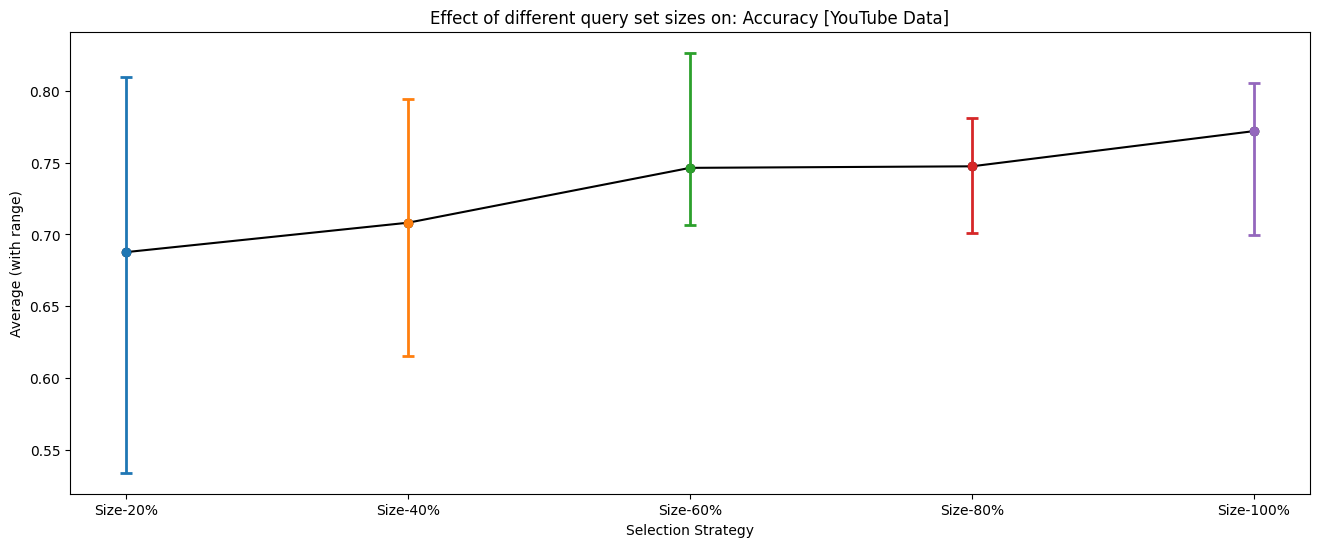

In [ ]:
graph_metric('acc')

### F-1 Score Graph

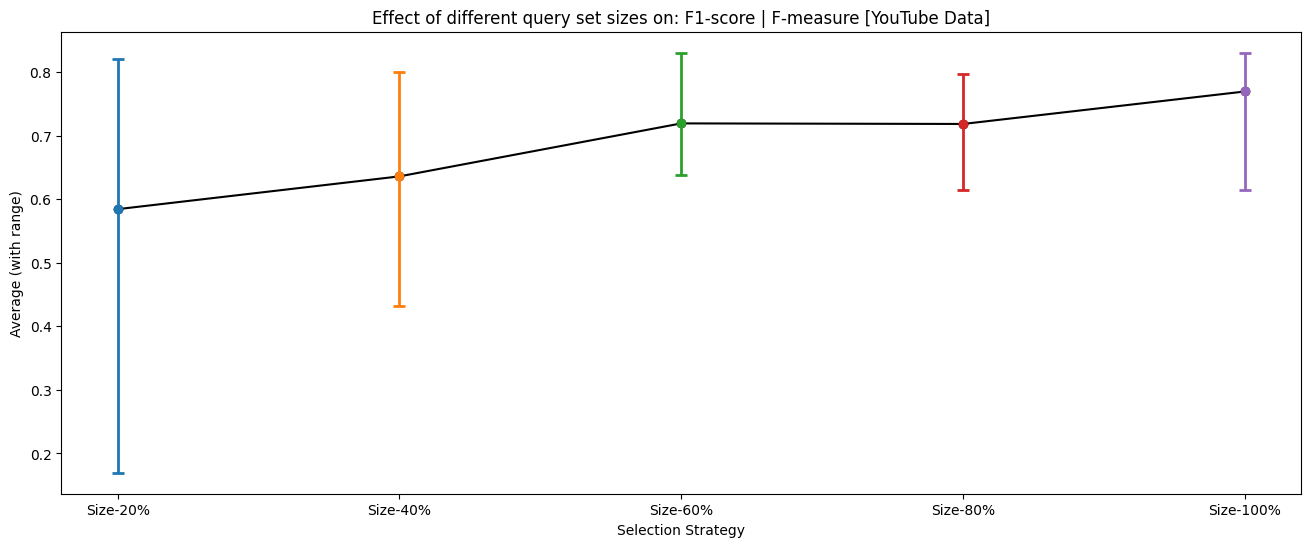

In [ ]:
graph_metric('f1')

### Precision Graphs

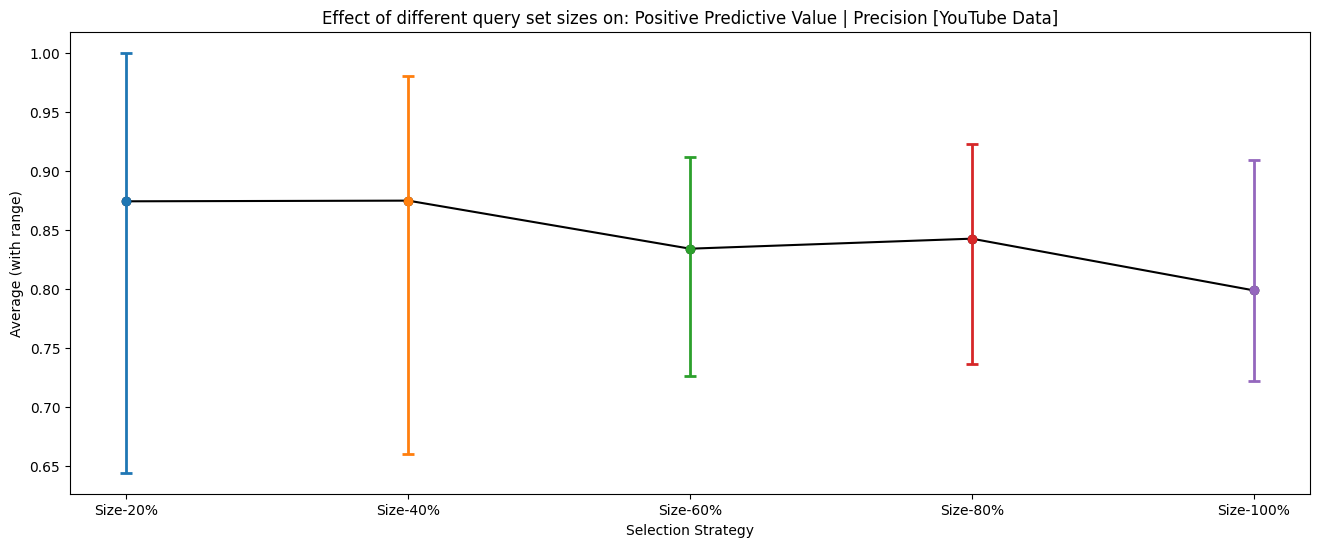

In [ ]:
graph_metric('ppv')

### Recall Graphs

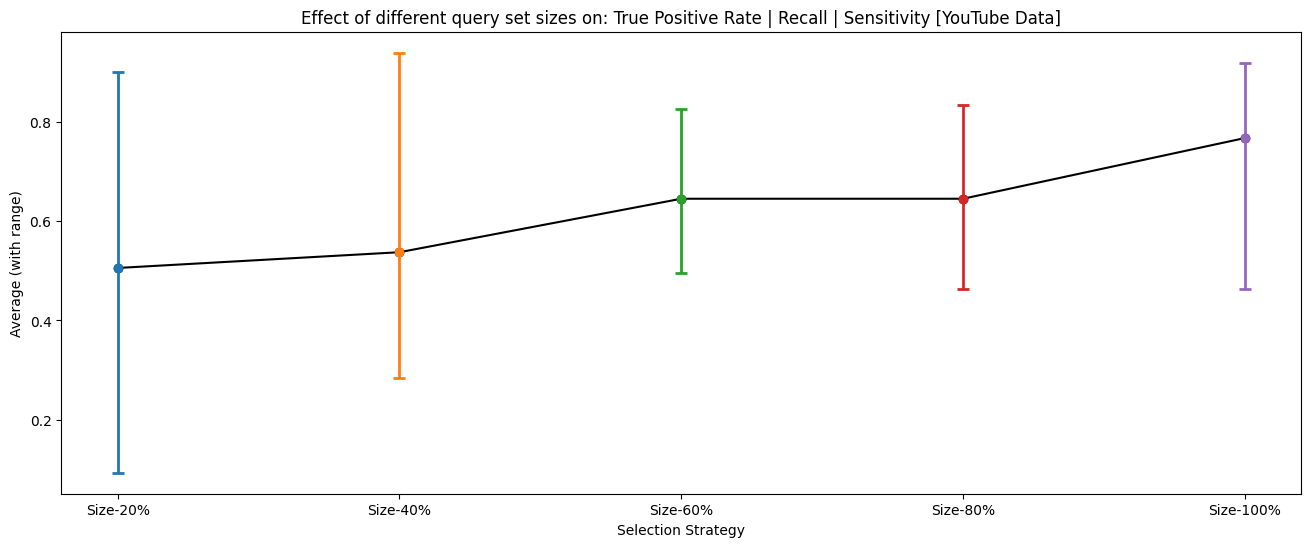

In [ ]:
graph_metric('tpr')

### Matthews Correlation Coefficient Graphs

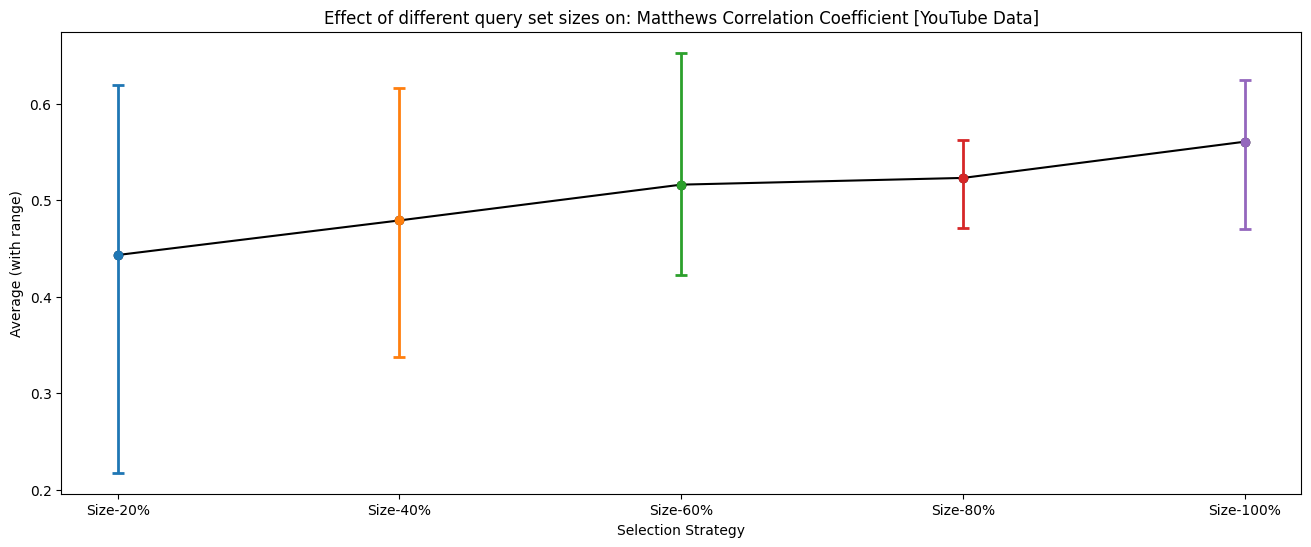

In [ ]:
graph_metric('mcc')

## Performance Graphs - Metric Variations

In [ ]:
def graph_variance(metric):

    data = Metric_stats[metric]

    # Extract data from the dictionary
    strategies = list(data.keys())
    averages = [data[strategy]['avg'] for strategy in strategies]
    std_devs = [data[strategy]['std_dev']/2 for strategy in strategies]
    colors = ['C{}'.format(i) for i in range(len(data))]  # One color for each strategy

    plt.figure(figsize=(16, 6))
    plt.bar(strategies, averages, yerr=std_devs, alpha = 0.3, capsize=5, color=colors)
    plt.xlabel('Selection Strategy')
    plt.ylabel('Average (with standard deviation)')
    plt.title('Variation caused by different query set sizes on: {} [YouTube Data]'.format(metric_dict[metric]))
    plt.show()

### Accuracy Variation

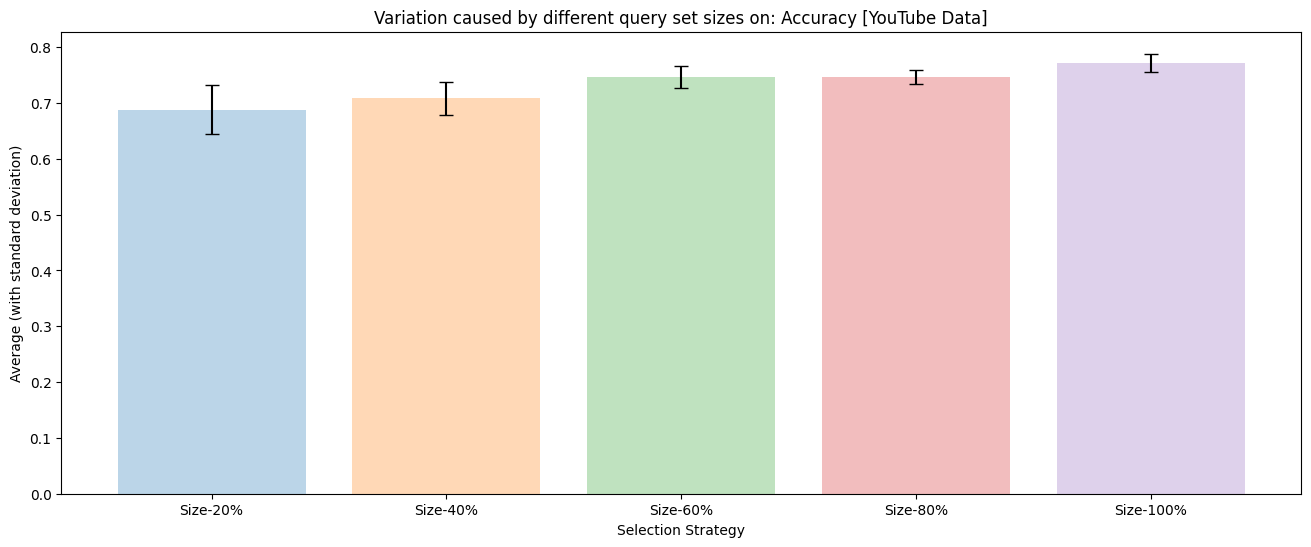

In [ ]:
graph_variance('acc')

### F1-Score Variation

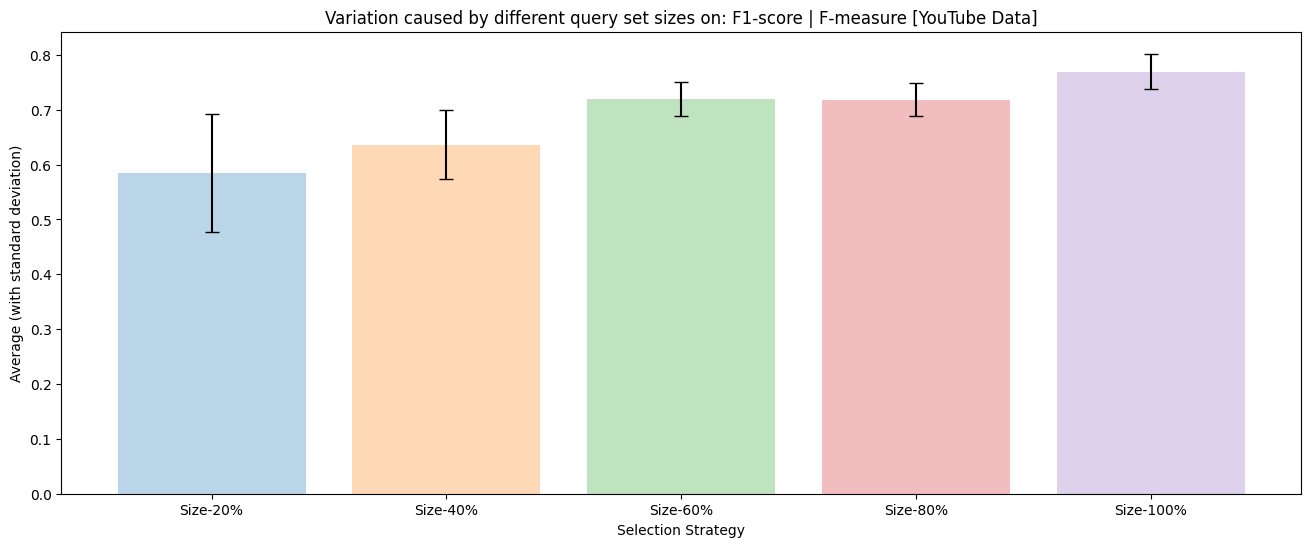

In [ ]:
graph_variance('f1')

### Precision Variation

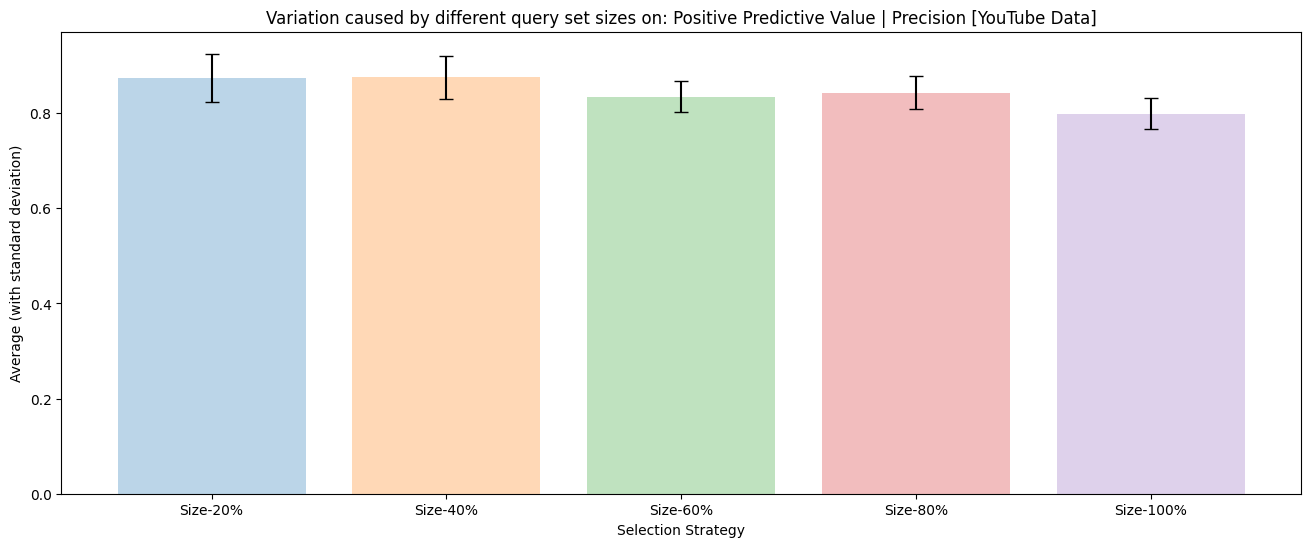

In [ ]:
graph_variance('ppv')

### Recall Variation

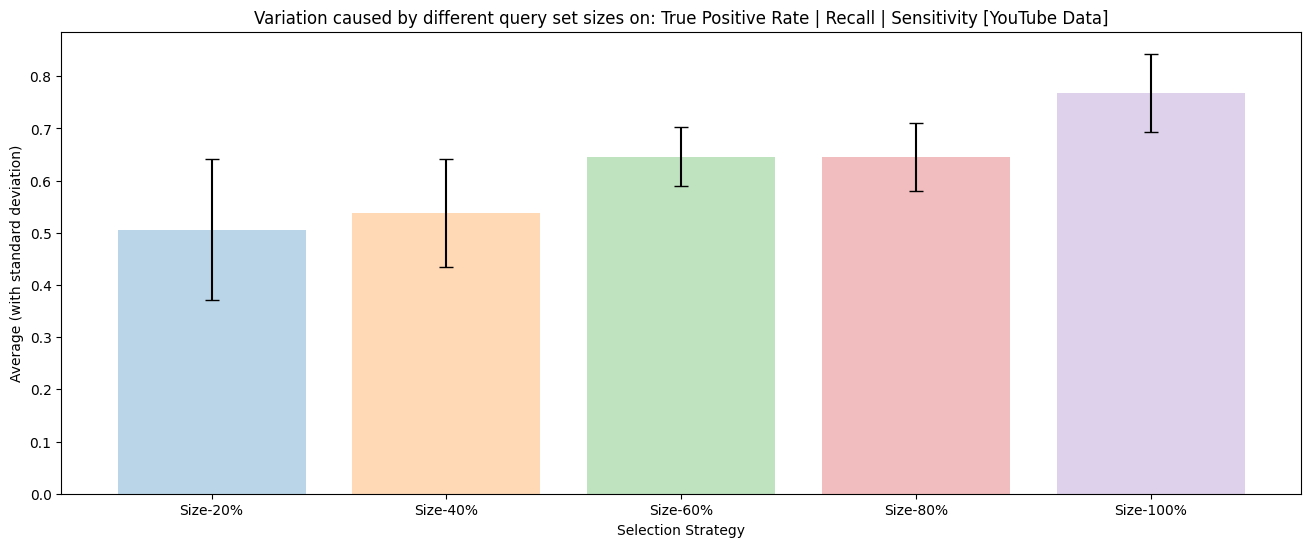

In [ ]:
graph_variance('tpr')

### Matthews Correlation Coefficient Variation

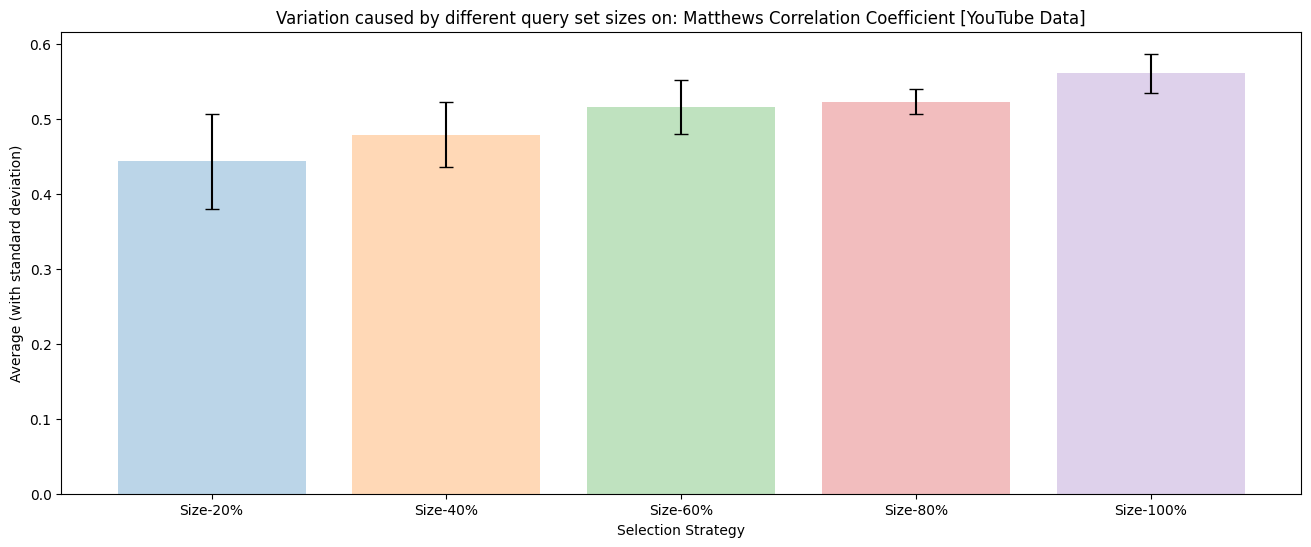

In [ ]:
graph_variance('mcc')